In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
import joblib

#### Load the Dataset

In [ ]:
# Load the dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\Source_Capstone_Data.xlsx"
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

#### Data Cleaning

In [17]:
# Drop unnecessary columns
columns_to_drop = [
    "D.[NamePostfix]", "F.[Name]", "G1.[ParameterID]", "G1.[Name]", "G1.[OperatorMessage]", 
    "G2.[ParameterID]", "G2.[Name]", "G2.[Description]", "G3.[ParameterID]", "G3.[Name]", 
    "G3.[OperatorMessage]", "A.[ParameterID]", "A.[EntryTimestamp]", "A.[DataValue]", 
    "A.[Description]", "B.[ParameterID]", "B.[EntryTimestamp]", "B.[DataValue]", 
    "B.[Description]", "C.[ParameterID]"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Convert measurement values to numeric
df['C.[DataValue]'] = pd.to_numeric(df['C.[DataValue]'], errors='coerce')

# Convert timestamps to datetime and sort
df['C.[EntryTimestamp]'] = pd.to_datetime(df['C.[EntryTimestamp]'], errors='coerce')
df = df.dropna(subset=['C.[EntryTimestamp]']).sort_values(by='C.[EntryTimestamp]').reset_index(drop=True)

# Outlier Removal Using IQR
Q1 = df["C.[DataValue]"].quantile(0.25)
Q3 = df["C.[DataValue]"].quantile(0.75)
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["C.[DataValue]"] >= lower_bound) & (df["C.[DataValue]"] <= upper_bound)].reset_index(drop=True)


#### Visualization and Statistical Methods

In [ ]:
# Ensure timestamps are sorted
df = df.sort_values(by="C.[EntryTimestamp]").reset_index(drop=True)
df["Time_Index"] = np.arange(len(df))  # Create a numerical index for time

# Time Series Plot
plt.figure(figsize=(10, 5))
plt.plot(df["C.[EntryTimestamp]"], df["C.[DataValue]"], alpha=0.5, label="Actual Data")
plt.plot(df["C.[EntryTimestamp]"], df["C.[DataValue]"].rolling(window=10).mean(), color="red", label="Rolling Mean (10 cycles)")
plt.xlabel("Time")
plt.ylabel("Bore Measurement")
plt.title("Bore Measurements Over Time")
plt.legend()
plt.show()

# Linear Trend Check
X = df[["Time_Index"]]
y = df["C.[DataValue]"]
lin_reg = LinearRegression().fit(X, y)
linear_r2 = lin_reg.score(X, y)

print(f"Linear Regression R² Score: {linear_r2:.4f}")
if linear_r2 < 0.5:
    print("No strong trend detected, indicating a non-linear pattern. Random Forest is justified.")

# Autocorrelation Plot
plot_acf(df["C.[DataValue]"], lags=50)
plt.title("Auto-Correlation Function (ACF) of Bore Measurements")
plt.show()

#### Feature Engineering

In [18]:
# Create Lag Features (past values)
for lag in [3, 5, 10, 15, 20]:
    df[f"DataValue_Lag{lag}"] = df["C.[DataValue]"].shift(lag)

# Create Differencing Features (rate of change)
df["Diff_Lag1"] = df["C.[DataValue]"].diff(1)
df["Diff_Lag3"] = df["C.[DataValue]"] - df["DataValue_Lag3"]
df["Diff_Lag5"] = df["C.[DataValue]"] - df["DataValue_Lag5"]
df["Diff_Lag10"] = df["C.[DataValue]"] - df["DataValue_Lag10"]

# Create Rolling Statistics (trend-based features)
df["Rolling_Mean_3"] = df["C.[DataValue]"].rolling(window=3).mean()
df["Rolling_Std_3"] = df["C.[DataValue]"].rolling(window=3).std()
df["Rolling_Mean_5"] = df["C.[DataValue]"].rolling(window=5).mean()
df["Rolling_Std_5"] = df["C.[DataValue]"].rolling(window=5).std()
df["Rolling_Mean_10"] = df["C.[DataValue]"].rolling(window=10).mean()
df["Rolling_Std_10"] = df["C.[DataValue]"].rolling(window=10).std()

# Distance to Tolerance Limits
df["Distance_to_MinValue"] = df["C.[DataValue]"] - df["C.[MinValue]"]
df["Distance_to_MaxValue"] = df["C.[MaxValue]"] - df["C.[DataValue]"]

# Define Target Variable
df["Target_NextCycle"] = df["C.[DataValue]"].shift(-1)

# Drop NaN values (from lagging and rolling features)
df = df.dropna().reset_index(drop=True)

# Define Feature List for RFR
rfr_features = [
    "C.[DataValue]", "DataValue_Lag3", "DataValue_Lag5", "DataValue_Lag10", "DataValue_Lag15", "DataValue_Lag20",
    "Diff_Lag1", "Diff_Lag3", "Diff_Lag5", "Diff_Lag10",
    "Rolling_Mean_3", "Rolling_Std_3", "Rolling_Mean_5", "Rolling_Std_5", "Rolling_Mean_10", "Rolling_Std_10",
    "Distance_to_MinValue", "Distance_to_MaxValue"
]

# Split Data into Training and Test Sets
train_size = int(0.8 * len(df))
X_train, X_test = df[rfr_features][:train_size], df[rfr_features][train_size:]
y_train, y_test = df["Target_NextCycle"][:train_size], df["Target_NextCycle"][train_size:]


#### Train Model

In [19]:
# Define Random Forest Regressor
rfr_model = RandomForestRegressor(
    n_estimators=200,         # Number of trees in the forest
    max_depth=10,             # Maximum depth of each tree
    min_samples_split=10,     # Minimum samples to split a node
    min_samples_leaf=5,       # Minimum samples required in a leaf node
    max_features="sqrt",      # Use a subset of features for each split
    bootstrap=True,           # Bootstrapping for randomness
    random_state=42           # Ensures reproducibility
)

# Train Random Forest Model
rfr_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200, random_state=42)

#### Model Evaluation

Random Forest Model Evaluation:
MAE: 0.0125
MSE: 0.0003
RMSE: 0.0166
R² Score: 0.4222


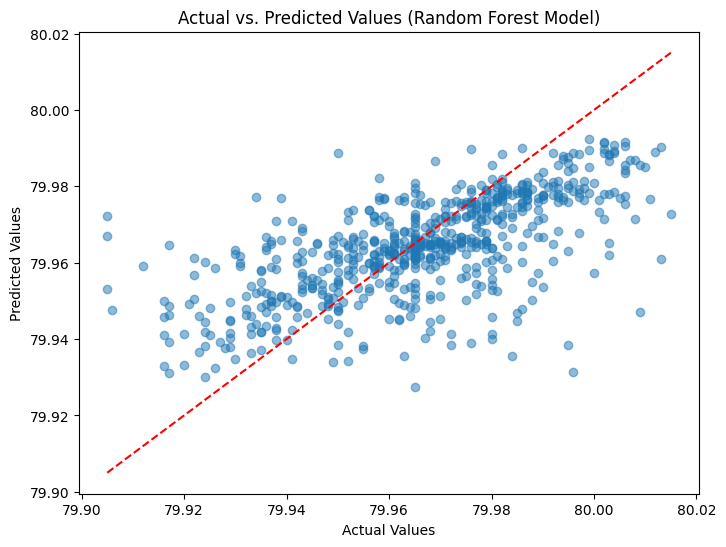

In [20]:
# Make Predictions (Use Random Forest Model)
y_pred = rfr_model.predict(X_test)  # No need for reshaping

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print Results
print("Random Forest Model Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # 45-degree reference line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Random Forest Model)")
plt.show()


#### Predict Future Wear

In [21]:
# Define how many future cycles to predict
future_cycles = 10  # Adjust as needed

# Ensure Cycle_Count exists in the dataset
df["Cycle_Count"] = np.arange(1, len(df) + 1)  # Assigns a unique cycle count

# Create a DataFrame for future predictions
future_df = pd.DataFrame()
future_df["Cycle_Count"] = range(df["Cycle_Count"].max() + 1, df["Cycle_Count"].max() + 1 + future_cycles)

# Use the last known values as the starting point for predictions
last_known_values = df.iloc[-1][rfr_features].to_dict()
predicted_bores = []

# Predict future bore sizes using the trained RFR model
for cycle in future_df["Cycle_Count"]:
    new_row = last_known_values.copy()

    # Shift lag values forward
    for lag in [3, 5, 10, 15, 20]:
        new_row[f"DataValue_Lag{lag}"] = predicted_bores[-lag] if len(predicted_bores) >= lag else last_known_values["C.[DataValue]"]

    # Update rolling statistics dynamically
    new_row["Rolling_Mean_3"] = np.mean(predicted_bores[-3:]) if len(predicted_bores) >= 3 else last_known_values["Rolling_Mean_3"]
    new_row["Rolling_Std_3"] = np.std(predicted_bores[-3:]) if len(predicted_bores) >= 3 else last_known_values["Rolling_Std_3"]
    new_row["Rolling_Mean_5"] = np.mean(predicted_bores[-5:]) if len(predicted_bores) >= 5 else last_known_values["Rolling_Mean_5"]
    new_row["Rolling_Std_5"] = np.std(predicted_bores[-5:]) if len(predicted_bores) >= 5 else last_known_values["Rolling_Std_5"]
    new_row["Rolling_Mean_10"] = np.mean(predicted_bores[-10:]) if len(predicted_bores) >= 10 else last_known_values["Rolling_Mean_10"]
    new_row["Rolling_Std_10"] = np.std(predicted_bores[-10:]) if len(predicted_bores) >= 10 else last_known_values["Rolling_Std_10"]

    # Convert to DataFrame and predict bore size using Random Forest
    new_X = pd.DataFrame([new_row])[rfr_features]
    predicted_bore = rfr_model.predict(new_X)[0]
    predicted_bores.append(predicted_bore)

    # Store predicted values in the DataFrame
    future_df.loc[future_df["Cycle_Count"] == cycle, "Predicted_Bore_Size"] = predicted_bore

# Compute bore size changes over time
future_df["Bore_Size_Change"] = future_df["Predicted_Bore_Size"].diff().fillna(0)

# Define wear classification function
def classify_wear(change):
    if change < 0.001:                    
        return "Normal Wear" 
    elif 0.001 <= change < 0.005:         
        return "Moderate Wear"
    else:
        return "Critical Wear"

# Assign wear labels to future cycles
future_df["Predicted_Wear_Stage"] = future_df["Bore_Size_Change"].apply(classify_wear)


#### Finalized Dataset

In [22]:
# Ensure actual data has necessary columns before merging
df["Predicted_Bore_Size"] = np.nan  # Set actual cycles to NaN in prediction column
df["Predicted_Wear_Stage"] = np.nan

# Ensure Cycle_Count exists in the actual dataset
df["Cycle_Count"] = np.arange(1, len(df) + 1)

# Concatenate actual and predicted data
final_df = pd.concat([df, future_df], ignore_index=True)

# Save predicted dataset
output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\rfr_future_wear_predictions.xlsx"
final_df.to_excel(output_path, index=False, engine="openpyxl")

# Display the final dataset
final_df


,D.[AssemblyName],C.[EntryTimestamp],C.[DataValue],C.[MinValue],C.[MaxValue],Time_Index,DataValue_Lag3,DataValue_Lag5,DataValue_Lag10,DataValue_Lag15,...,Rolling_Std_5,Rolling_Mean_10,Rolling_Std_10,Distance_to_MinValue,Distance_to_MaxValue,Target_NextCycle,Cycle_Count,Predicted_Bore_Size,Predicted_Wear_Stage,Bore_Size_Change
0,D0445162,2022-03-11 06:12:44.980,79.972,79.905,80.025,23.0,79.963,79.954,79.952,79.984,...,0.007701,79.9672,0.010706,0.067,0.053,79.991,1,NaN,NaN,NaN
1,D0445181,2022-03-11 07:26:11.013,79.991,79.905,80.025,24.0,79.954,79.973,79.983,79.984,...,0.013874,79.9680,0.012211,0.086,0.034,79.971,2,NaN,NaN,NaN
2,D0445177,2022-03-11 08:35:11.610,79.971,79.905,80.025,25.0,79.965,79.963,79.957,79.945,...,0.013465,79.9694,0.011597,0.066,0.054,79.959,3,NaN,NaN,NaN
3,D0445082,2022-03-12 08:40:19.033,79.959,79.905,80.025,26.0,79.972,79.954,79.983,79.920,...,0.012033,79.9670,0.010934,0.054,0.066,79.977,4,NaN,NaN,NaN
4,D0445018,2022-03-12 09:57:02.890,79.977,79.905,80.025,27.0,79.991,79.965,79.968,79.940,...,0.011576,79.9679,0.011387,0.072,0.048,79.971,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3233,79.983706,Normal Wear,-0.000962
3233,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3234,79.983643,Normal Wear,-0.000063
3234,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3235,79.983643,Normal Wear,0.000000
3235,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3236,79.983686,Normal Wear,0.000044
